# Decision Tree Hyperparamter Tuning
## 1. Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

preprocessed_df = pd.read_csv("../data manipulation/preprocessed_cycling_tdf.csv", index_col=0)

# split into train data (pre 2023), and test data 2023
test_df = preprocessed_df[preprocessed_df['season'] == 2023]
train_df = preprocessed_df[preprocessed_df['season'] != 2023]

# now remove season time series data
test_df = test_df.drop("season", axis=1)
train_df = train_df.drop("season", axis=1)


columns = [column for column in list(test_df.columns) if column != "tdf attended"]
X_test = test_df[columns]
Y_test = test_df[["tdf attended"]]
X_train = train_df[columns]
Y_train = train_df[["tdf attended"]]

# function that creates local copy of X,Y for train and test
# and takes bool to include team data or not
def local_variables(with_teams = True):
    """function that creates local copy of X,Y for train and test
         and takes bool weither to include team data or not"""
    columns = X_test.columns.tolist()
    if not with_teams:
        columns_no_teams = []
        for column in columns:
            if column[:4] != "team":
                columns_no_teams.append(column)
        columns = columns_no_teams
    X_test_n = X_test.copy()[columns]
    X_train_n = X_train.copy()[columns]

    return X_test_n , Y_test.copy(), X_train_n, Y_train.copy()


X_test_local, Y_test_local, X_train_local, Y_train_local = local_variables()
X_test_local, Y_test_local, X_train_local, Y_train_local = local_variables(False)

In [2]:
print(len(X_test_local.columns.tolist()))

10


##  2. Hyperparamter Tuning
Data without teams is used

In [25]:
X_test, Y_test, X_train, Y_train = local_variables(False)

### I. Decision Tree
#### Grid Search Parameters
- **CV** number of cross-validation sets, 5 seems reasonable
- **score**: which score to take for evalution: clearly F1 score, see Experimentation

#### Decision Tree Hyperparameters

##### Quality of Split
- **Gini:** Measures misclassification of a randomly chosen element, minimized when all elements belong to the same class. Quantifies how often a randomly chosen element would be incorrectly classified based on the distribution of class labels in a given node. the Gini criterion encourages the tree to make splits that result in nodes with predominantly pure class distributions,
- **Entropy:** Used for information gain in the splitting process.

##### Splitter
- **Best Split:** Chooses the best possible split for nodes.
- **Random Split:** Not an option, as logical splits are preferred over random ones.

##### Max Depth
- **-5**: also small sizes added since first tuning gave 5 as a result
- **5-10:** Medium depth, less prone to overfitting.
- **More than 20:** Can capture complex relationships but prone to overfitting; testing up to 50 for complex data.

##### Min Samples Split
- Minimum number of samples required to split an internal node during tree construction.
  - 5 seems logical; consider higher values like 20 for overfitting prevention.

##### Min Samples Leaf
- Minimum number of samples required to be at a leaf node to reduce overfitting.
  - 1 can be meaningful, especially for outstanding cases; consider outliers like Tadej Pogacar.

##### Max Features
- Number of features to consider when looking for the best split.
  - **None:** Do not limit max features.
  - **Sqrt:** Square root of all features left.
  - **Log2:** Logarithm base 2 of all features left.
  - **3:** Estimate, considering 10 attributes in the dataset.

##### Random State
- Seed value to produce the same results in each run.
  - random int such as 7
  - or no seed:None

##### Min Weight Fraction Leaf
- Minimum weighted fraction required to be at a leaf node.
  - Already sufficient overfitting prevention; not in use.

##### Max Leaf Nodes
- Controls the number of terminal nodes.
  - Already have depth control; not needed.

##### Min Impurity Decrease
- Used for early stopping tree growth.
  - Not deemed necessary.

##### Class Weight
- Assigns different weights to classes.
  - **None:** All classes have the same weight.
  - **Balanced:** Adjusts weights inversely proportional to class frequencies; useful for avoiding imbalance. Sadly an error occurs concerning an sklearn error with grid search and Decision tree expcting an attribute dict, but getting stirng. as result will not be considered
  - **Dictionary:** Assigns weights to each class; not necessary with no strong imbalance detected.

##### CCP Alpha
- Used for Minimal Cost-Complexity Pruning.
  - Not considered due to sufficient overfitting measures in place.


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier


dectree = DecisionTreeClassifier()

# Hyperparameters to consider
param_grid = {
        'criterion': ['gini', 'entropy',],
        'splitter': ['best'],
        'max_depth': [3,5, 10, 15],
        'min_samples_split': [50,90,100,120,140,160],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [None, 'sqrt', 'log2'],
        #"class_weight":["None","balanced"]
        "random_state":[None, 7]
        }


# Perform Grid Search Cross-Validation
# cv5 is 5th fold cross validation (see pdf presentation)
# scoring for setting target best F1
grid_search_dectree = GridSearchCV(estimator=dectree, param_grid=param_grid, cv=5, scoring="f1")   
grid_search_dectree.fit(X_train, Y_train)

# Print the best hyperparameters found
print("Best Hyperparameters for Decision Tree: ", grid_search_dectree.best_params_)


Best Hyperparameters for Decision Tree:  {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 100, 'random_state': None, 'splitter': 'best'}


In [6]:
# after two adjustments (every time min or max value was picked as optimum added more values)
# this is the solution
decision_tree_best_parameters = {
    'criterion': 'gini', 
    'max_depth': 5, 
    'max_features': None, 
    'min_samples_leaf': 1, 
    'min_samples_split': 50, 
    'random_state': None, 
    'splitter': 'best'}
more_minsampleslpit_changescoretof1 =  {
    'criterion': 'entropy', 
    'max_depth': 10, 
    'max_features': None, 
    'min_samples_leaf': 4, 
    'min_samples_split': 70, 
    'random_state': 7, 
    'splitter': 'best'}
addingmore_minsampleslit = {'criterion': 'entropy', 
          'max_depth': 10, 
          'max_features': None, 
          'min_samples_leaf': 4, 
          'min_samples_split': 100, 
          'random_state': None, 
          'splitter': 'best'}
addingmore_minsampleslit2= {
    'criterion': 'entropy', 
    'max_depth': 10, 
    'max_features': None, 
    'min_samples_leaf': 4, 
    'min_samples_split': 100, 
    'random_state': None, 
    'splitter': 'best'}
# since no change now this is the grid i use

In [14]:
# Train the model with the best combination of hyperparameters

decision_tree = DecisionTreeClassifier(
    criterion ='entropy', 
    max_depth = 10, 
    max_features = None, 
    min_samples_leaf = 4, 
    min_samples_split = 100, 
    random_state = None, 
    splitter = 'best')
decision_tree.fit(X_train, Y_train)

y_pred_dt = decision_tree.predict(X_test)

### Randomized Forrest

In [32]:
from sklearn.ensemble import RandomForestClassifier

# Random Forrest
# Tune hyperparameters, find the best set of hyperparameters
randomforrest = RandomForestClassifier()


param_grid = {'n_estimators':[10,50,100], 
              'max_depth':[None, 2, 4, 10, 25, 100],
              'min_samples_split':[2, 5, 10],
              'min_samples_leaf':[2,5,10],
              'bootstrap':[True, False],
              'verbose':[0]
              }

"""   
n_estimators: number of trees, good range 10,50, 100
oob_score: set to f1 score
n_jobs: nooo gridsv already utilizes f1
verbose: we dont want anything to be shown
warm_start: i dont want to use existing trees as a start
similar to decision tree: criterion, max_depth, min_samples_split, min_samples_leaf, min_weight_fraction_leaf, max_features, max_leaf_nodes, min_impurity_decrease, bootstrap, random_state, class weight, cc_alpha, max_samples
"""

grid_search_randomforest = GridSearchCV(estimator=randomforrest, param_grid=param_grid, cv=5)   # cv5 is 5th fold cross validation (see pdf presentation)
grid_search_randomforest.fit(X_train, Y_train)

# Print the best hyperparameters found
print("Best Hyperparameters for Random Forrest: ", grid_search_randomforest.best_params_)


C:\Users\hutte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hutte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hutte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

Best Hyperparameters for Random Forrest:  {'bootstrap': False, 'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'verbose': 0}


In [ ]:
# timeline of best hyperparamter results
hyper_parameters = {
    'bootstrap': False, 
    'max_depth': 25, 
    'min_samples_leaf': 2, 
    'min_samples_split': 5, 
    'n_estimators': 100, 
    'verbose': 0}

In [35]:
# Train the model with the best combination of hyperparameters

random_forrest = RandomForestClassifier(bootstrap=False, max_depth=25, min_samples_leaf= 2, min_samples_split=5, n_estimators= 100)
random_forrest.fit(X_train, Y_train)

y_pred_rf = random_forrest.predict(X_test)

C:\Users\hutte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


## 3. Evaluate
on F1 Score

#### Decision Tree
Interesting to see is that this tuned decision tree is better than untuned random forrest in experimentation

In [16]:
from sklearn.metrics import classification_report


decision_tree_acc = classification_report(Y_test, y_pred_dt)

print("Decision Tree:\n ", decision_tree_acc)

Decision Tree:
                precision    recall  f1-score   support

       False       0.91      0.70      0.79       408
        True       0.48      0.81      0.60       144

    accuracy                           0.72       552
   macro avg       0.70      0.75      0.70       552
weighted avg       0.80      0.72      0.74       552



#### Random forrest

In [37]:
from sklearn.metrics import classification_report

random_forrest_acc = classification_report(Y_test, y_pred_rf)

print("Random Forrest: \n", random_forrest_acc)


Random Forrest: 
               precision    recall  f1-score   support

       False       0.86      0.84      0.85       408
        True       0.58      0.62      0.60       144

    accuracy                           0.78       552
   macro avg       0.72      0.73      0.73       552
weighted avg       0.79      0.78      0.79       552



## 4. Visualize

https://stackoverflow.com/questions/27817994/visualizing-decision-tree-in-scikit-learn


### Plot Decision Tree
#### with hyperparamtertuning

In [26]:
# Very low decision tree needed
decision_tree_pruned = DecisionTreeClassifier(
    criterion ='entropy', 
    max_depth = 3, 
    max_features = None, 
    min_samples_leaf = 4,   # only change max depth to 3
    min_samples_split = 100, 
    random_state = None, 
    splitter = 'best')
decision_tree_pruned.fit(X_train, Y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=4,
                       min_samples_split=100)

In [27]:
from sklearn import tree

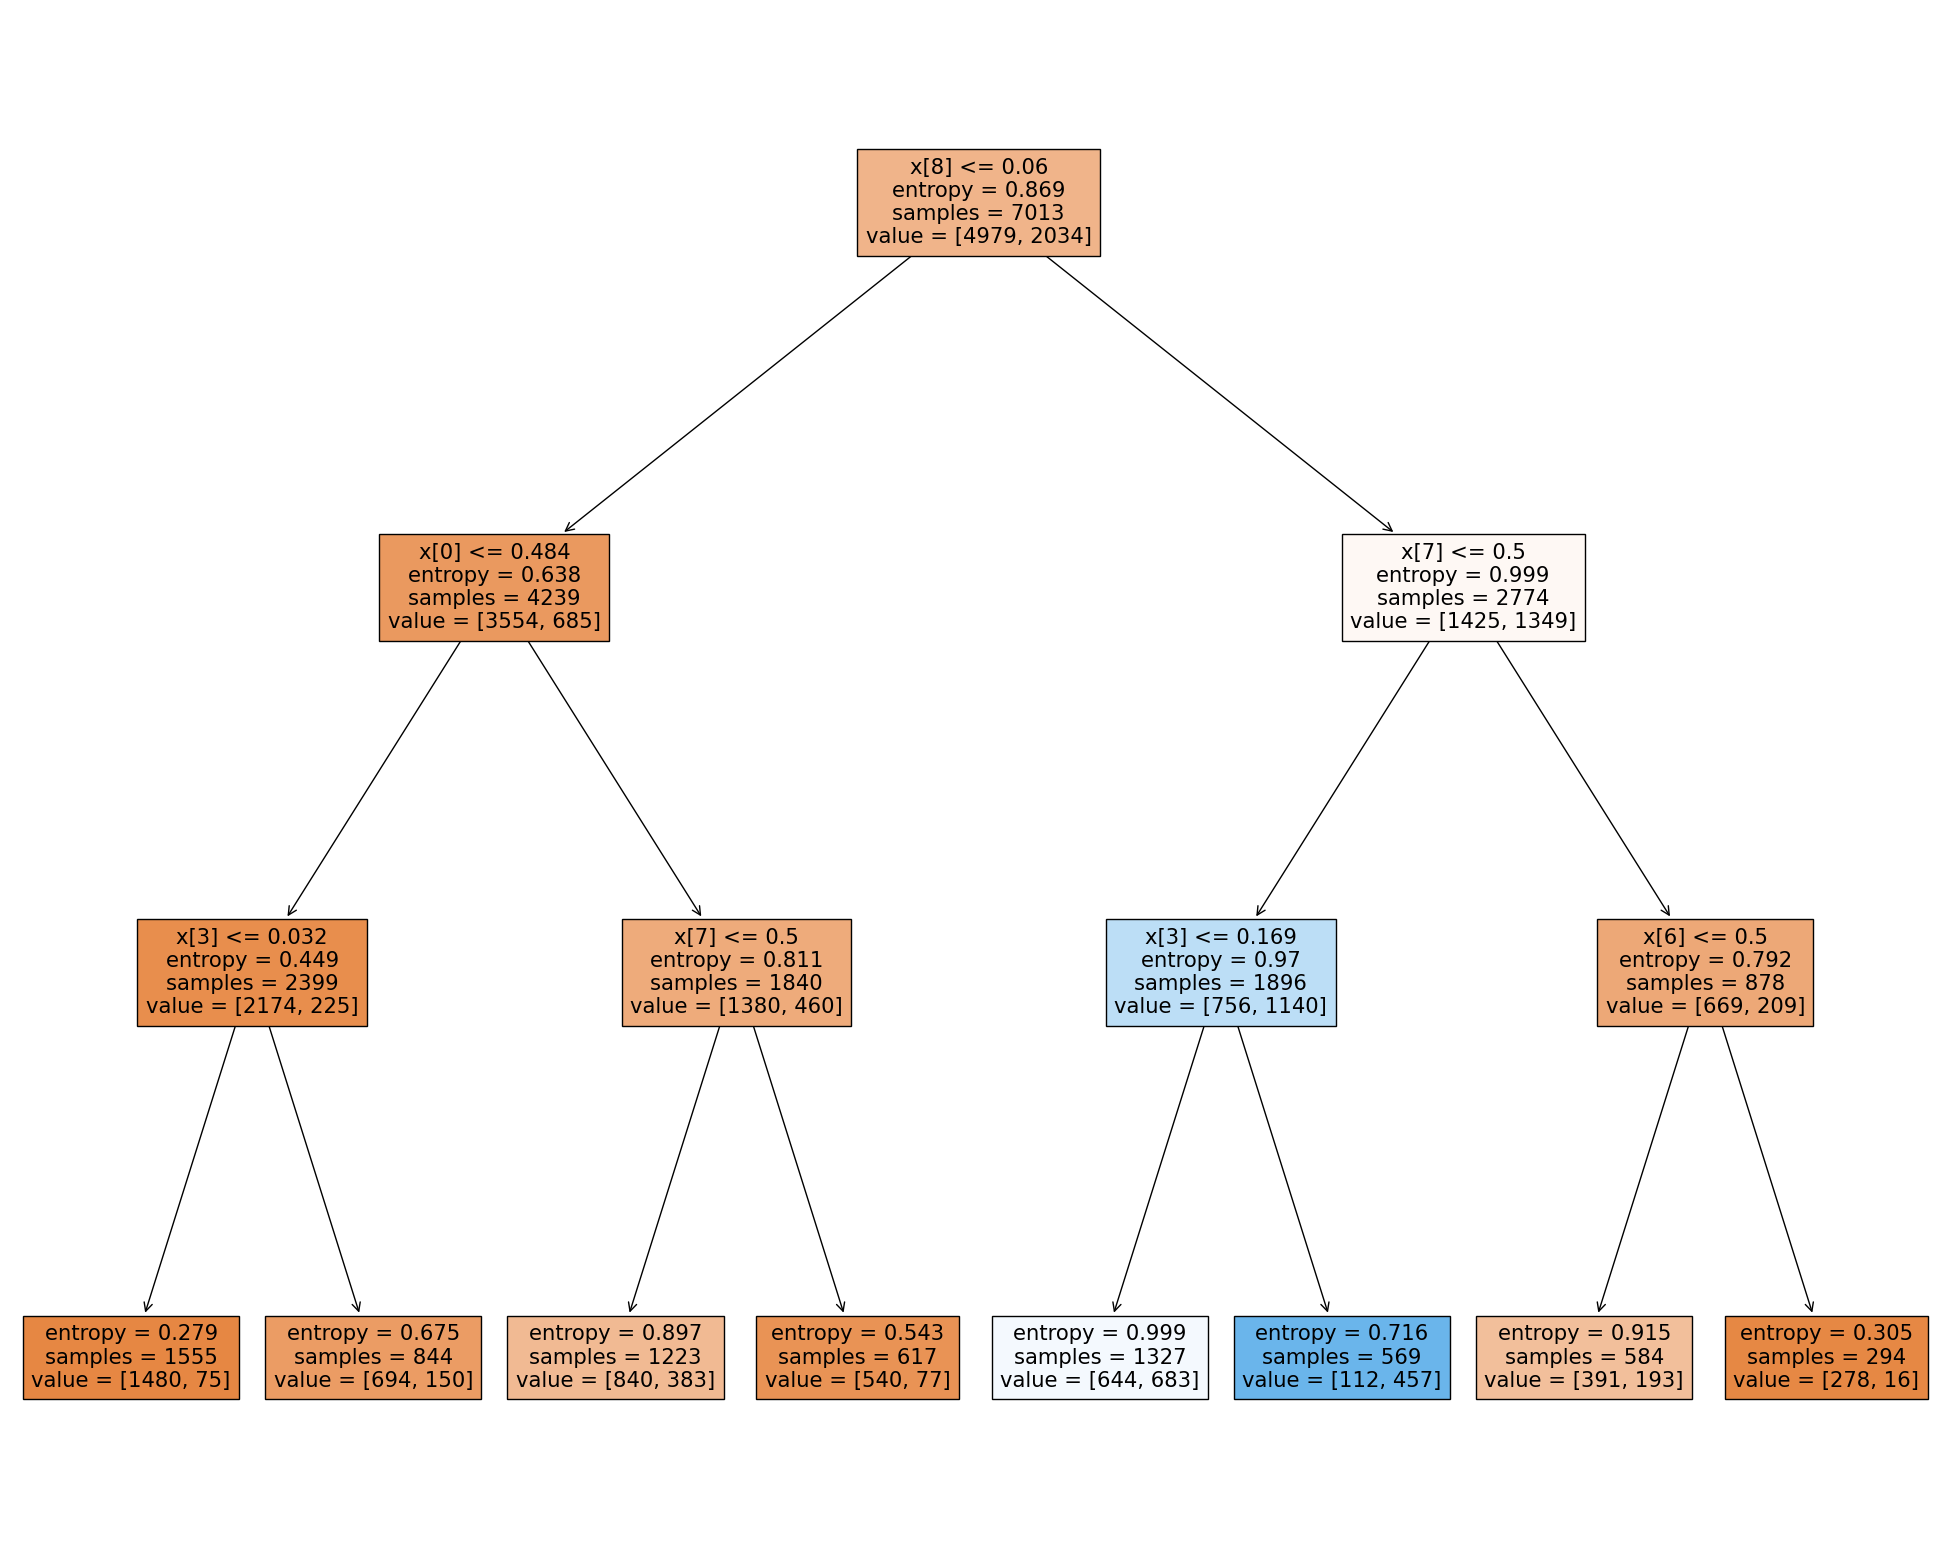

In [47]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(decision_tree_pruned, filled=True)
fig.savefig("decistion_tree.png")

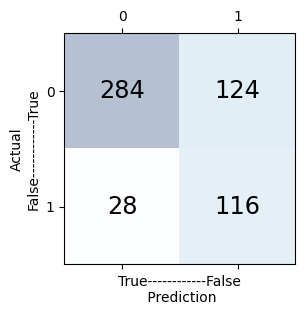

In [46]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test,y_pred_dt)
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
plt.ylabel("Actual\nFalse------------True")
plt.xlabel("True------------False\n Prediction")
plt.show()
